# Welcome to the notebook

### Task 1 - Set up the project environment

https://www.coursera.org/learn/genai-for-data-analysis-openai-assistant-api/lecture/mHlmn/5-create-charts-and-parse-image-files

In [1]:
!pip install openai==1.7.2 python-dotenv

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.1/212.1 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.8/77.8 kB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 7.5 MB/s eta 0:00:00


Importing modules

In [2]:
# Connecting to colab
from google.colab import drive
drive.mount('/content/drive') #, force_remount=True


Mounted at /content/drive


In [3]:
import pandas as pd
import os, time
from openai import OpenAI
from dotenv import load_dotenv
from PIL import Image
from io import BytesIO

print("Modules are imported.")

Modules are imported.


Setting up the OpenAI API:

* Prepare a .env file to store the OpenAI API key.
* Uploading the .env file to our colab environment
* Load the API key and setup the API

In [4]:
load_dotenv("apikey.env.txt")
APIKEY = os.getenv("APIKEY")

Creating OpenAI Client

In [5]:
client = OpenAI(api_key = APIKEY)

### Task 2 - Create the AI Assistant

Now let's load our dataset into a File Object

In [6]:
data_file = client.files.create(
  file = open("product_sales_dataset.json", "rb"),
  purpose = "assistants"
  )
data_file

FileObject(id='file-U64JwnECBnBcNrJjh7w5jci0', bytes=1456230, created_at=1709316603, filename='product_sales_dataset.json', object='file', purpose='assistants', status='processed', status_details=None)

Let's define our Assistant object.

In [7]:
name = "Data Analyst"
description = """
You are a data analyst.
You know how to analyze data and extract insights.
You will be given a json file containing the data related to an online toy store and you use your data analysis and coding skills to answer the
users analytical questions about this data
"""


In [8]:
model = "gpt-3.5-turbo-0125"
assistant = client.beta.assistants.create(
    name=name,
    description=description,
    model=model, #currently, the other one is not available
    tools=[{"type": "code_interpreter"}],
    file_ids=[data_file.id]
)


### Task 3 - Communicate with the AI Assistant through Threads

> The **User** can communicate with the AI assistant through a **Thread** object. A thread can contain one or multiple **Message** objects. <br>
> We can then use a **Run** object to send our message to the AI assistant.




Let's define an empty thread. 🧵


In [9]:
thread = client.beta.threads.create()
thread

Thread(id='thread_Uspk4Lq24GO6ZtxMxm58cbo6', created_at=1709316604, metadata={}, object='thread')

Now let's create a message and add it to thread.

In [10]:
question =  "Examine the contents of the file uploaded and anaswer the question; What is the item that has the highest number of items sold?"
message = client.beta.threads.messages.create(
    thread_id=thread.id,
    role = "user",
    content = question
)

Creating a `Run` object to send our request to the AI Assistant.

In [11]:
run = client.beta.threads.runs.create(
    thread_id = thread.id,
    assistant_id=assistant.id,
)

### Task 4 - Retrieve results from the AI Assistant

Let's retrieve the run object to check the status of the run

In [18]:
response_run = client.beta.threads.runs.retrieve(
    run_id=run.id,
    thread_id = thread.id,

)
response_run.status

'failed'

In [19]:
response_run

Run(id='run_Es63q1WPB3lMWPlsH5xwwc9f', assistant_id='asst_Tm5GxMwRcrn9YvajYQWPJwZi', cancelled_at=None, completed_at=None, created_at=1709316604, expires_at=None, failed_at=1709316620, file_ids=['file-U64JwnECBnBcNrJjh7w5jci0'], instructions=None, last_error=LastError(code='rate_limit_exceeded', message='Rate limit reached for gpt-3.5-turbo-0125 in organization org-0Qx0KP6PalUQzyQZrFaHTTHw on requests per min (RPM): Limit 3, Used 3, Requested 1. Please try again in 20s. Visit https://platform.openai.com/account/rate-limits to learn more. You can increase your rate limit by adding a payment method to your account at https://platform.openai.com/account/billing.'), metadata={}, model='gpt-3.5-turbo-0125', object='thread.run', required_action=None, started_at=1709316604, status='failed', thread_id='thread_Uspk4Lq24GO6ZtxMxm58cbo6', tools=[ToolAssistantToolsCode(type='code_interpreter')], usage={'prompt_tokens': 888, 'completion_tokens': 216, 'total_tokens': 1104})

Now let's retrieve the messages from the AI Assistant

In [14]:
messages = client.beta.threads.messages.list(
    thread_id=thread.id
)

In [15]:
for msg in list(messages):
  print(msg.content[0].text.value)

Examine the contents of the file uploaded and anaswer the question; What is the item that has the highest number of items sold?


### Task 5 - Create charts with AI Assistant

In [16]:
def send_message(assistant_id, thread_id, message_content):
      """
      Sends a message to an AI assistant,
      waits for the response run to be completed,
      and then retrieves the list of messages in the thread.
      """

      # creating message
      message = client.beta.threads.messages.create(
        thread_id = thread_id,
        role = "user",
        content = message_content
      )

      # creating request run
      request_run = client.beta.threads.runs.create(
            thread_id = thread_id,
            assistant_id = assistant_id
      )

      # wait until the response_run is completed
      while True:
            # retrieve the run
            response_run = client.beta.threads.runs.retrieve(
                  thread_id = thread_id,
                  run_id = request_run.id
            )

            print("status > "+response_run.status)

            time.sleep(1)

            if(response_run.status=="completed"):
              time.sleep(1)
              break

      messages = client.beta.threads.messages.list(
            thread_id = thread_id
      )

      return list(messages)

In [20]:
question = "In which day of the week do we have the highest number of sold items"
messages = send_message(assistant.id, thread.id, question)
print(messages)

status > in_progress
status > in_progress
status > in_progress
status > in_progress
status > in_progress
status > in_progress
status > in_progress
status > in_progress
status > in_progress
status > in_progress
status > completed
[ThreadMessage(id='msg_HGyrKleMpcTqN7g2OOO74YyC', assistant_id='asst_Tm5GxMwRcrn9YvajYQWPJwZi', content=[MessageContentText(text=Text(annotations=[], value='Based on the analysis of the data, we have found the following total number of sold items for each day of the week:\n\n- Monday: 63,851 items sold\n- Tuesday: 57,117 items sold\n- Wednesday: 58,661 items sold\n- Thursday: 63,164 items sold\n- Friday: 82,279 items sold\n- Saturday: 106,705 items sold\n- Sunday: 109,296 items sold\n\nTherefore, the day of the week with the highest number of sold items is **Sunday**, with a total of 109,296 items sold.'), type='text')], created_at=1709316697, file_ids=[], metadata={}, object='thread.message', role='assistant', run_id='run_50xES4tnHs84XaeM4Vd0sVMi', thread_id='

Let's ask the assistant to create a histogram of the product price column.

In [21]:
question = "Create a histogram of the product price column"
message = send_message(assistant.id, thread.id, question)

answer = message[0]
print(answer)

status > in_progress
status > in_progress
status > in_progress
status > in_progress
status > in_progress
status > in_progress
status > in_progress
status > in_progress
status > in_progress
status > in_progress
status > in_progress
status > completed
ThreadMessage(id='msg_sbKVIuEwPcUz3bDFFQEFP4yA', assistant_id='asst_Tm5GxMwRcrn9YvajYQWPJwZi', content=[MessageContentImageFile(image_file=ImageFile(file_id='file-uefDFDoQFV1catBU6lIK7Qk4'), type='image_file'), MessageContentText(text=Text(annotations=[], value="Here is the histogram of the 'Product Price' column, showing the distribution of product prices in the dataset. The x-axis represents the product prices in dollars, while the y-axis shows the frequency of each price range.\n\nPlease let me know if you need any further analysis or if you have any other questions."), type='text')], created_at=1709316941, file_ids=[], metadata={}, object='thread.message', role='assistant', run_id='run_eWzL6D6UGVXpnF8stGKfxqA0', thread_id='thread_Uspk4L

Let's take a look at the answer and extract the image file

In [29]:
file_id = answer.content[0].image_file.file_id
print(file_id)

file-uefDFDoQFV1catBU6lIK7Qk4


Let's retrieve the file

In [31]:
#client.files.content(file_id).read()

In [32]:
image_data=client.files.content(file_id).read()

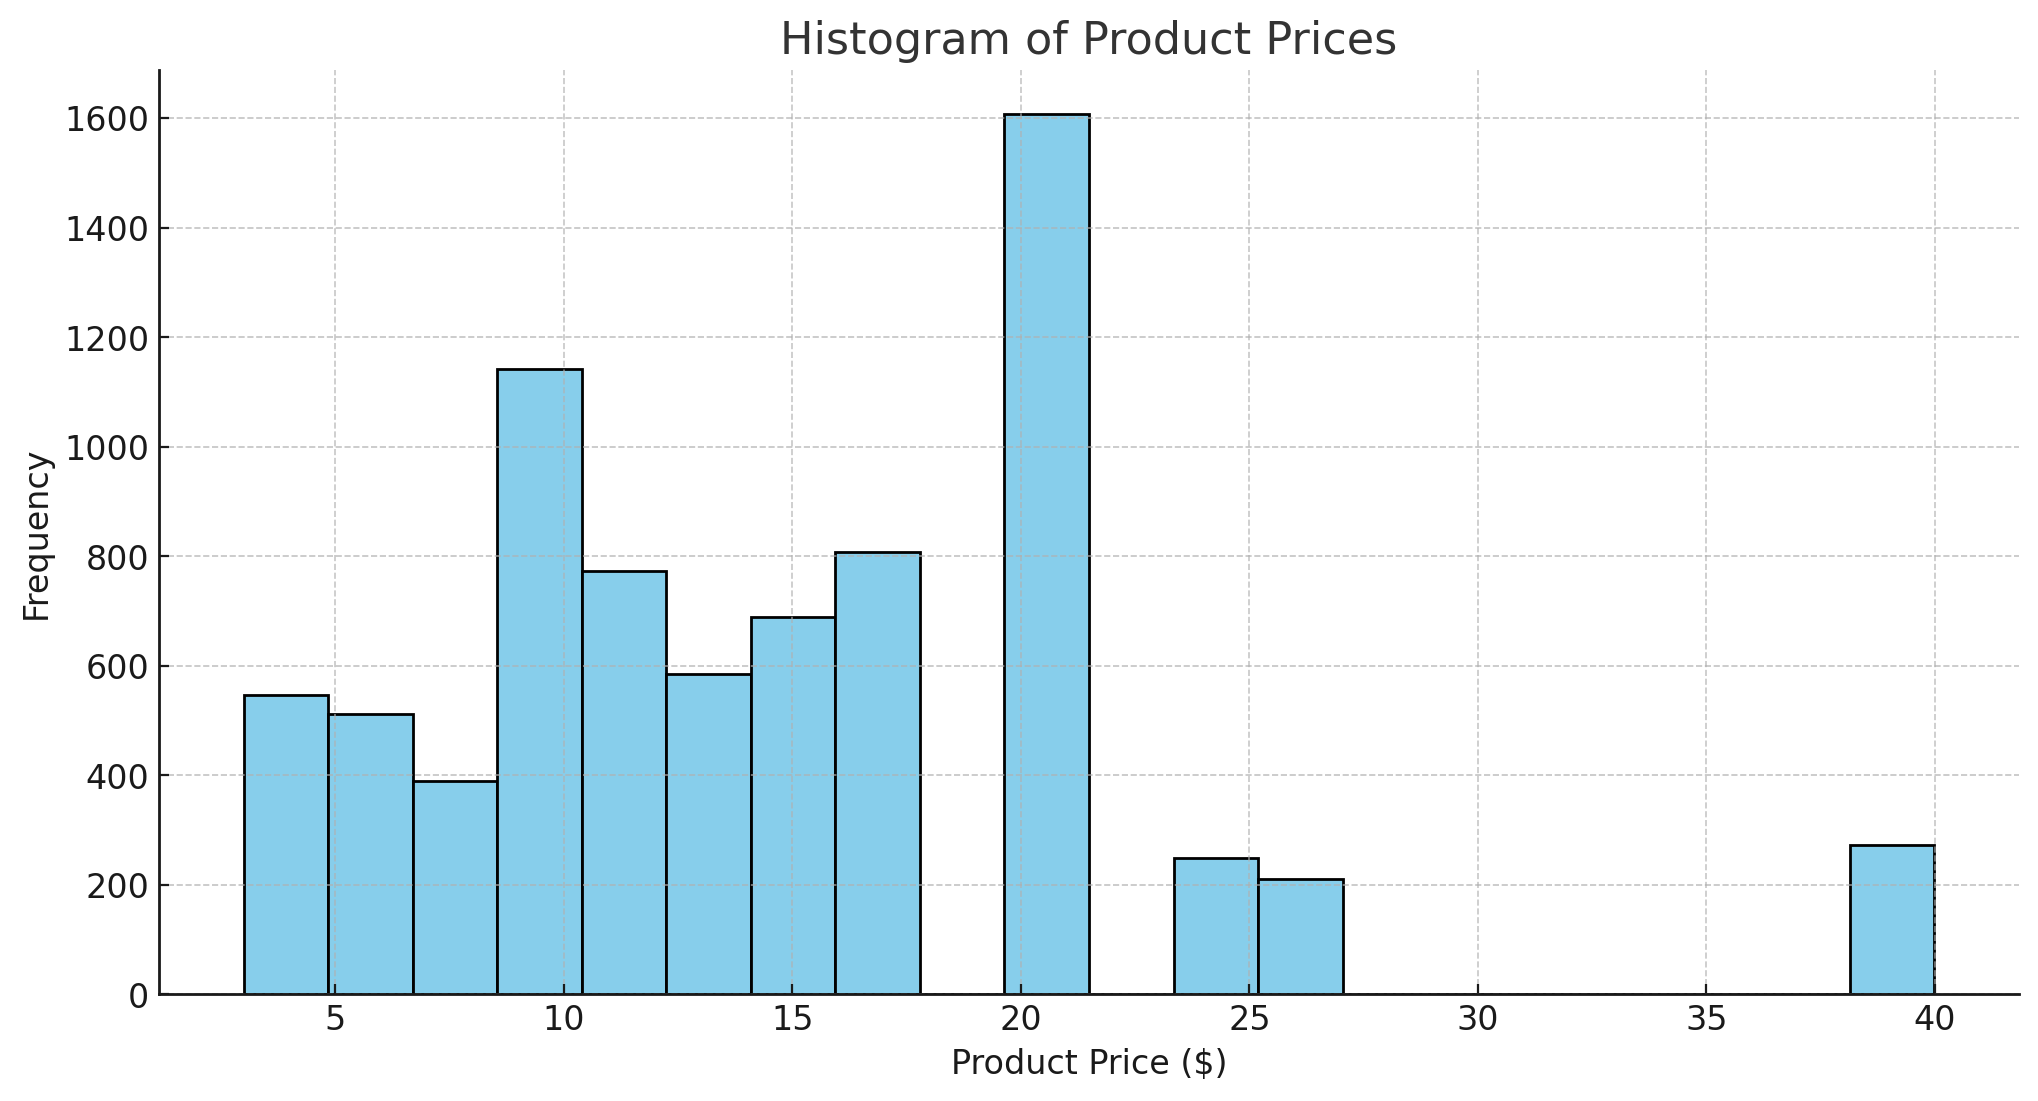

In [33]:
image = Image.open(BytesIO(image_data))
image